# Advanced segmentation

<h1>Advanced segmentation</h1>
<br/>
<p>
    <b>Quantitative Big Imaging</b> ETHZ: 227-0966-00L
    <br/>
    <b>Part 1:</b> Advanced segmentation
</p>
<br/>
<p style="font-size:1em;">March 23, 2023</p>
<br /><br />
<p style="font-size:1.5em;padding-bottom: 0.25em;">Anders Kaestner</p>  
<p style="font-size:1em;">Laboratory for Neutron Scattering and Imaging<br />Paul Scherrer Institut</p>

## Today's Outline

- Motivation
 - Many Samples
 - Difficult Samples
 - Training / Learning
- Thresholding
 - Automated Methods
 - Hysteresis Method

*** 

- Feature Vectors
 - K-Means Clustering
 - Superpixels
- Working with Segmented Images
 - Contouring


## Literature / Useful References

- [Superpixels](http://ivrg.epfl.ch/research/superpixels)


## Load some needed modules

In [3]:
from skimage.io import imread
import matplotlib.pyplot as plt

import numpy as np
from skimage.morphology import dilation, opening, disk
from collections import OrderedDict
from skimage.data import page
import skimage.filters as flt
import pandas as pd
from skimage.filters import gaussian, median, threshold_triangle
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
%matplotlib inline

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

 
## Previously on QBI

- Image acquisition and representations
- Enhancement and noise reduction
- Understanding models and interpreting histograms
- Ground Truth and ROC Curves

*** 

- Choosing a threshold
 - Examining more complicated, multivariate data sets
- Improving segementation with morphological operations
 - Filling holes
 - Connecting objects
 - Removing Noise
- Partial Volume Effect

## Different types of segmentation

When we talk about image segmentation there are different meanings to the word. In general, segmenation is an operation that marks up the image based on pixels or pixel regions. This is a task that has been performed since beginning of image processing as it is a natural step in the workflow to analyze images - we must know which regions we want to analyze and this is a tedious and error prone task to perform manually. Looking at the figure below we two type of segmentation.

![](figures/imagesegmentation.png)

- Object detection - identifies regions containing an object. The exact boundary does not matter so much here. We are only interested in a bounding box.
- Semantic segmentation - classifies all the pixels of an image into meaningful classes of objects. These classes are “semantically interpretable” and correspond to real-world categories. For instance, you could isolate all the pixels associated with a cat and color them green. This is also known as dense prediction because it predicts the meaning of each pixel.

- Instance segmentation - Identifies each instance of each object in an image. It differs from semantic segmentation in that it doesn’t categorize every pixel. If there are three cars in an image, semantic segmentation classifies all the cars as one instance, while instance segmentation identifies each individual car.

# Where segmentation fails

Segmentation using a single threshold is sensitive to different conditions...

In fact, segmentation is rarely an obvious task. What you want to find is often obscured by other image features and unwanted artefacts from the experiment technique. If you take a glance at the painting by Bev Doolittle, you quickly spot the red fox in the middle. Looking a little closer at the painting, you'll recognize two indians on their spotted ponies. This example illustrates the problems you will encounter when you start to work with image segmentation.

```{figure} figures/doolittle_woodlandencounter.png
---
scale: 75%
---
Cases making the segmentation task harder than just applying a single threshold.
```

<figure><img src="figures/doolittle_woodlandencounter.png" style="height:500px" /></figure>

_Woodland Encounter_ Bev Doolittle

## Typical image features that makes life harder

The basic segmentation shown in the previous lecture can only be used under good conditions when the classes are well separated. Images from many experiments are unfortunately not well-behaved in many cases. The figure below shows four different cases when an advanced technique is needed to segment the image. Neutron images often show a combination of all cases. 

The impact on the segmentation performance of all these cases can be reduced by proper experiment planning. Still, sometimes these improvements are not fully implemented in the experiment to be able to fulfill other experiment criteria.  

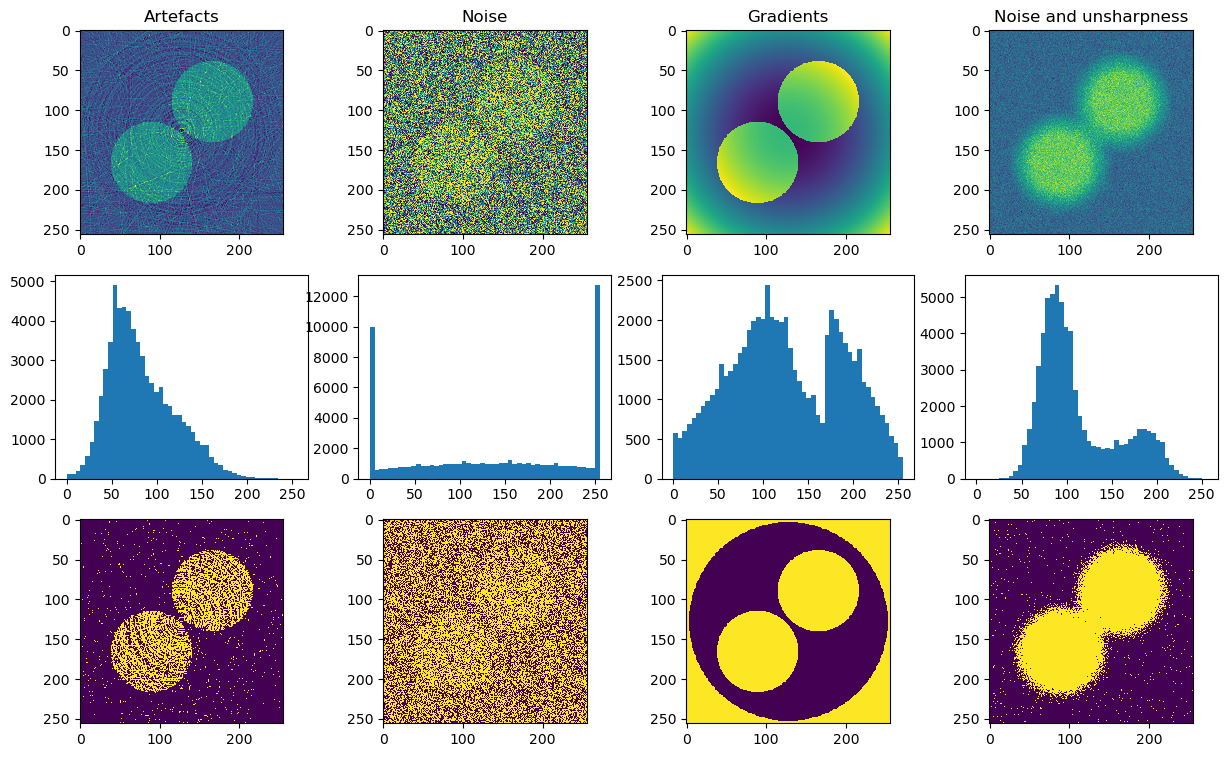

In [4]:
files  = ['class_art_in.png','class_wgn_in.png','class_cupped_in.png','class_wgn_smooth_in.png']
titles = ['Artefacts','Noise','Gradients','Noise and unsharpness']

plt.figure(figsize=[15,9])
for i in range(4) :
    img = imread('data/'+files[i])
    plt.subplot(3,4,i+1), plt.imshow(img,interpolation='none'), plt.title(titles[i])
    plt.subplot(3,4,i+5), plt.hist(img.ravel(),bins=50)
    plt.subplot(3,4,i+9), plt.imshow(120<img,interpolation='none')

## Inconsitent illumination on real data

Under realistic experiment conditions it may happen that the illumation fluctuates. This results in inconsistently illuminated images.

In this particular example of a cell colony, there is a random bias added to the images. 

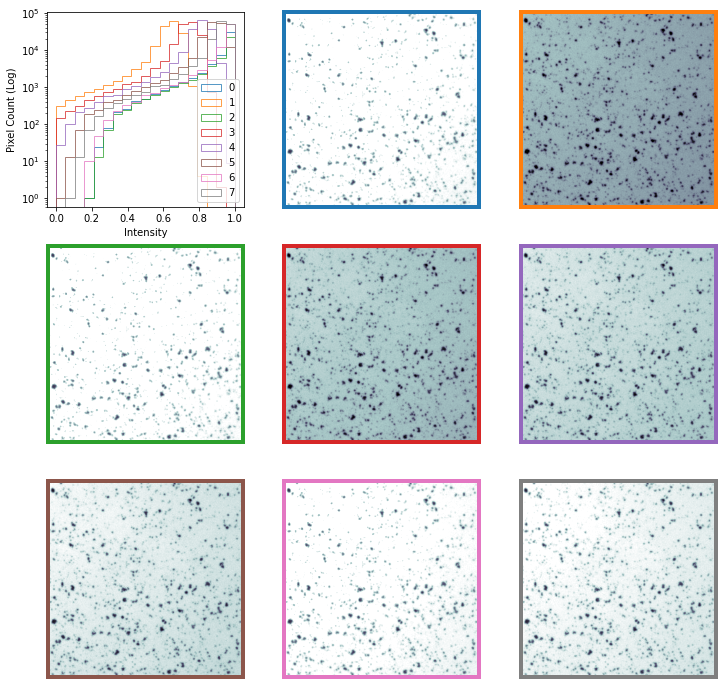

In [5]:
cell_img = imread("figures/Cell_Colony.jpg")/255.0
np.random.seed(2018)
m_cell_imgs = [cell_img+k for k in np.random.uniform(-0.25, 0.25, size = 8)]
fig, m_axs = plt.subplots(3, 3, figsize = (12, 12), dpi = 72)
ax1 = m_axs[0,0]
for i, (c_ax, c_img) in enumerate(zip(m_axs.flatten()[1:], m_cell_imgs)):
    ax1.hist(c_img.ravel(), np.linspace(0, 1, 20),
             label = '{}'.format(i), alpha = 0.75, histtype = 'step')
    c_ax.imshow(c_img, cmap = 'bone', vmin = 0, vmax = 1)
#     c_ax.axis('off')
    c_ax.set_xticks([]);
    c_ax.set_yticks([]);
    for axis in ['top','bottom','left','right']:
        c_ax.spines[axis].set_linewidth(4)
        c_ax.spines[axis].set_color(colors[i])
    
ax1.set_yscale('log', nonpositive = 'clip')
ax1.set_ylabel('Pixel Count (Log)')
ax1.set_xlabel('Intensity')
ax1.legend();

## Apply a treshold
When we apply a constant threshold of 0.6 to the images with different illuminations we just looked at you will see that there are great differences in how the cells are represented.

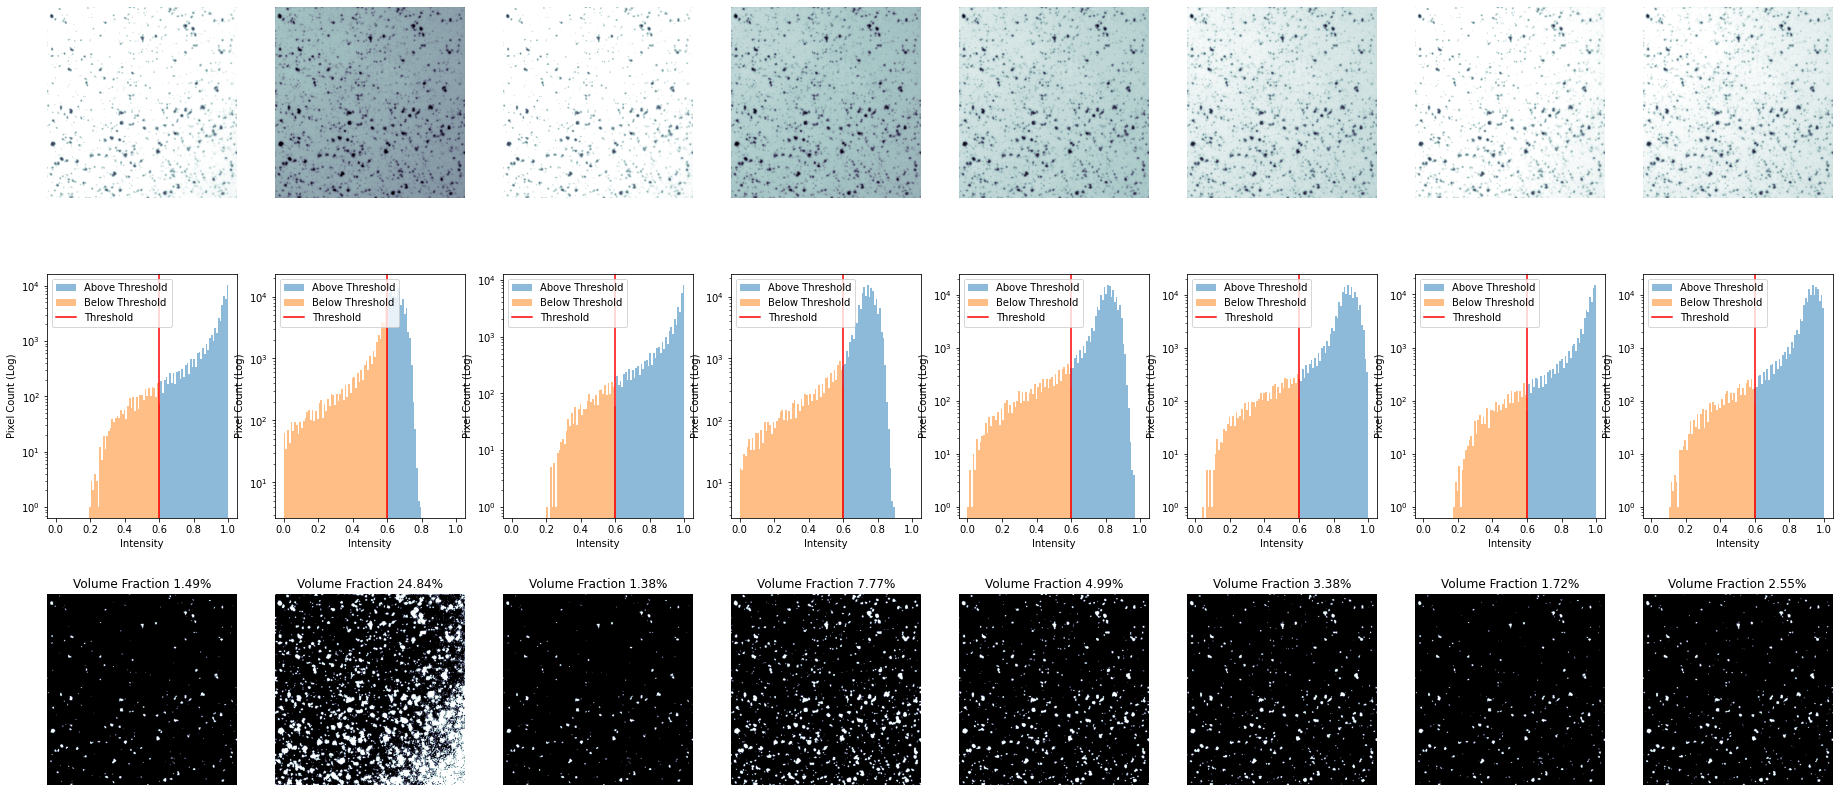

In [9]:
fig, m_axs = plt.subplots(3,len(m_cell_imgs), 
                          figsize = (4*len(m_cell_imgs), 5*3), 
                          dpi = 72)
THRESH_VAL = 0.6

for i, ((ax0, ax1, ax2), c_img) in enumerate(zip(m_axs.transpose(), m_cell_imgs)):
    ax0.imshow(c_img, cmap = 'bone', vmin = 0, vmax = 1)
    ax0.axis('off')
    ax1.hist(c_img.ravel()[c_img.ravel()>THRESH_VAL], 
             np.linspace(0, 1, 100), 
             label = 'Above Threshold', 
             alpha = 0.5)
    ax1.hist(c_img.ravel()[c_img.ravel()<THRESH_VAL], 
             np.linspace(0, 1, 100), 
             label = 'Below Threshold', 
             alpha = 0.5)
    ax1.axvline(THRESH_VAL,color='r',label='Threshold');
    ax1.set_yscale('log', nonpositive = 'clip'); ax1.set_ylabel('Pixel Count (Log)'); ax1.set_xlabel('Intensity'); ax1.legend()
    ax2.imshow(c_img<THRESH_VAL, cmap = 'bone', vmin = 0, vmax = 1)
    ax2.set_title('Volume Fraction {0:2.2f}%'.format(100*np.mean(c_img.ravel()<THRESH_VAL))), ax2.axis('off');

## Where segmentation fails: Canaliculi

![Bone Slice](figures/bonegfiltslice.png)

### Here is a bone slice

1. Find the larger cellular structures (osteocyte lacunae)
1. Find the small channels which connect them together

***

__The first task__ 
is easy using a threshold and size criteria (we know how big the cells should be)

__The second__
is much more difficult because the small channels having radii on the same order of the pixel size are obscured by 
- partial volume effects 
- and noise.

## Where segmentation fails: Brain Cortex

```{figure} figures/cortex_mask.png
---
scale: 50%
---
Brain image with masked cortex.
```

<img src="figures/cortex_mask.png" style="width:20%"/>

- The cortex is barely visible to the human eye
- Tiny structures hint at where cortex is located

__Our problem__ 

- A simple threshold is insufficient to finding the cortical structures
- Other filtering techniques are unlikely to magicially fix this problem

# Apply thresholds

In [6]:
%matplotlib inline
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np

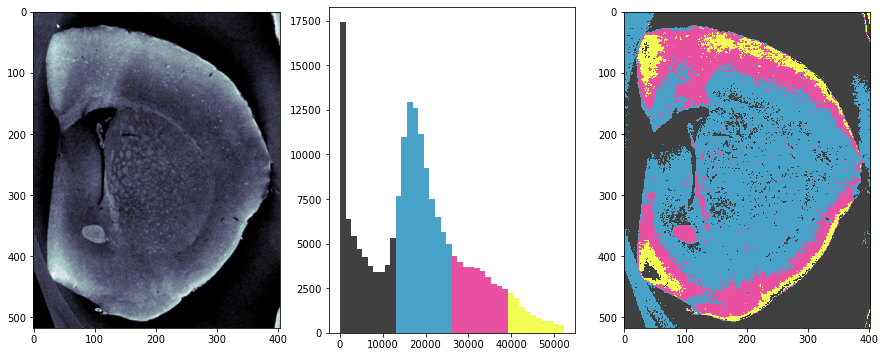

In [16]:
cortex_img = imread("figures/cortex.png")
np.random.seed(2018)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, 
                                    figsize = (15, 6))
ax1.imshow(cortex_img, cmap = 'bone')

clst = np.array([[64,64,64],
                 [73,162,199],
                 [234,80,162],
                 [241,254,83]])/255.0
cmap = colors.ListedColormap(clst)

thresh_vals = np.linspace(cortex_img.min(), cortex_img.max(), 4+2)[:-1]
out_img = np.zeros_like(cortex_img)
for i, (t_start, t_end) in enumerate(zip(thresh_vals, thresh_vals[1:])):
    thresh_reg = (cortex_img>t_start) & (cortex_img<t_end)
    ax2.hist(cortex_img.ravel()[thresh_reg.ravel()],color=clst[i])
    out_img[thresh_reg] = i
ax3.imshow(out_img, cmap = cmap,interpolation='none');

## Automated Threshold Selection

![Many possible automated techniques](figures/automaticthresh.png)

Given that applying a threshold is such a common and signficant step, there have been many tools developed to automatically (unsupervised) perform it. A particularly important step in setups where images are rarely consistent such as outdoor imaging which has varying lighting (sun, clouds). The methods are based on several basic principles. 

## Automated Methods


### Histogram-based methods
Just like we visually inspect a histogram an algorithm can examine the histogram and find local minimums between two peaks, maximum / minimum entropy and other factors

- Otsu, Isodata, Intermodes, etc

### Image based Methods
These look at the statistics of the thresheld image themselves (like entropy) to estimate the threshold  


### Results-based Methods
These search for a threshold which delivers the desired results in the final objects. For example if you know you have an image of cells and each cell is between 200-10000 pixels the algorithm runs thresholds until the objects are of the desired size
- More specific requirements need to be implemented manually

## Histogram-based Methods


Taking a typical image of a bone slice, we can examine the variations in calcification density in the image

***

We can see in the histogram that there are two peaks, one at 0 (no absorption / air) and one at 0.5 (stronger absorption / bone)


In [8]:
%matplotlib inline
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np

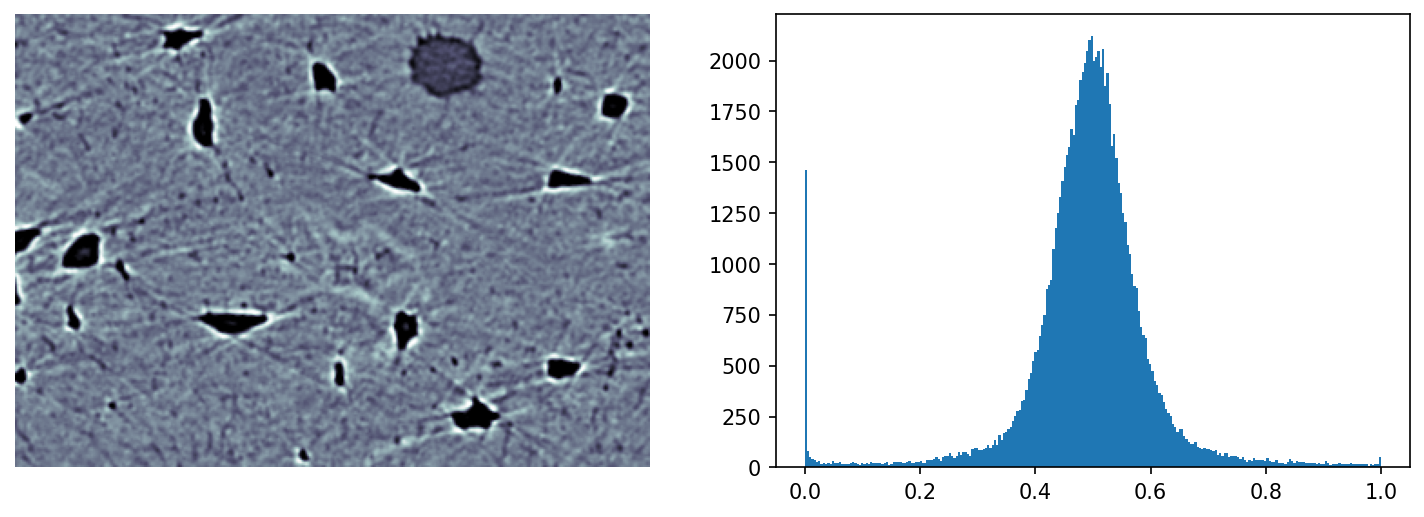

In [9]:
bone_img = imread("figures/bonegfiltslice.png")/255.0
np.random.seed(2018)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (12, 4), dpi = 150)
ax1.imshow(bone_img, cmap = 'bone')
ax1.axis('off')
ax2.hist(bone_img.ravel(), bins=256);

## Histogram-Methods

***

### Intermodes
 - Take the point between the two modes (peaks) in the histogram


### Otsu

Search and minimize intra-class (within) variance
$$\sigma^2_w(t)=\omega_{bg}(t)\sigma^2_{bg}(t)+\omega_{fg}(t)\sigma^2_{fg}(t)$$

### Isodata

- Initialize with: $\textrm{thresh}= \frac{\max(img)+\min(img)}{2}$
- _while_ the thresh is changing
 - $bg = img<\textrm{thresh}, obj = img>\textrm{thresh}$
 - Update $\textrm{thresh} = (\textrm{avg}(bg) + \textrm{avg}(obj))/2$

## Try All Thresholds

- [opencv2](https://docs.opencv.org/2.4/doc/tutorials/imgproc/threshold/threshold.html)
- [scikit-image](http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_thresholding.html)

There are many methods and they can be complicated to implement yourself. 

Both Fiji and scikit-image offers many of them as built in functions so you can automatically try all of them on your image.


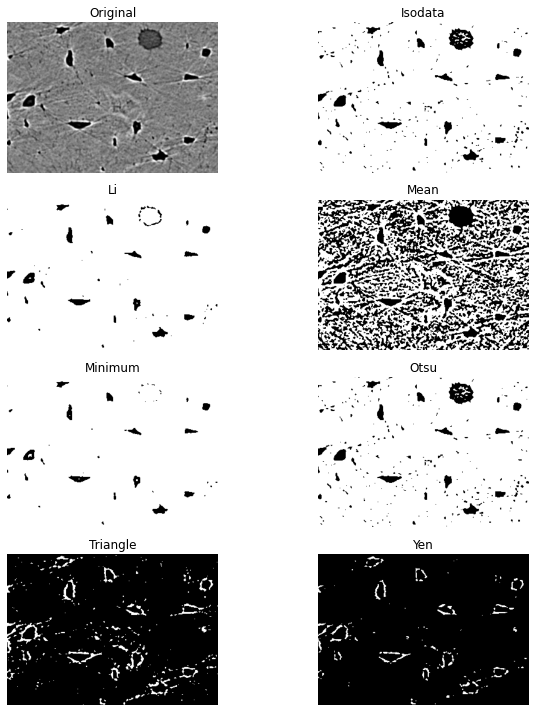

In [11]:
bone_img = imread("figures/bonegfiltslice.png")/255.0

from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(bone_img, figsize=(10, 10), verbose=False);

## Pitfalls of different thresholding methods

While an incredibly useful tool, there are many potential pitfalls to these automated techniques. 

### Histogram-based

These methods are very sensitive to the distribution of pixels in your image and may work really well on images with equal amounts of each phase but work horribly on images which have very high amounts of one phase compared to the others

### Image-based

These methods are sensitive to noise and a large noise content in the image can change statistics like entropy significantly. 

### Results-based

These methods are inherently biased by the expectations you have. 
- If you want to find objects between 200 and 1000 pixels - you will! 
- they just might not be anything meaningful.

## Realistic Approaches for Dealing with these Shortcomings


Imaging science rarely represents the ideal world and will never be 100% perfect. At some point we need to write our master's thesis, defend, or publish a paper. These are approaches for more qualitative assessment we will later cover how to do this a bit more robustly with quantitative approaches

### Model-based

One approach is to 
- try and simulate everything (including noise) as well as possible 
- and to apply these techniques to many realizations of the same image 
- and qualitatively keep track of how many of the results accurately identify your phase or not. 

__Hint:__ >95% seems to convince most biologists

### Sample-based

- Apply the methods to each sample and keep track of which threshold was used for each one. 
- Go back and apply each threshold to each sample in the image 
- and keep track of how many of them are correct enough to be used for further study.

### Worst-case Scenario

Come up with the worst-case scenario (noise, misalignment, etc) and assess how inacceptable the results are. Then try to estimate the quartiles range (75% - 25% of images).

## Hysteresis Thresholding

For some images a single threshold does not work
- large structures are very clearly defined
- smaller structures are difficult to differentiate (see [partial volume effect](http://bit.ly/1mW7kdP))

[ImageJ Source](http://imagejdocu.tudor.lu/doku.php?id=plugin:segmentation:hysteresis_thresholding:start)

In [12]:
%matplotlib inline
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np

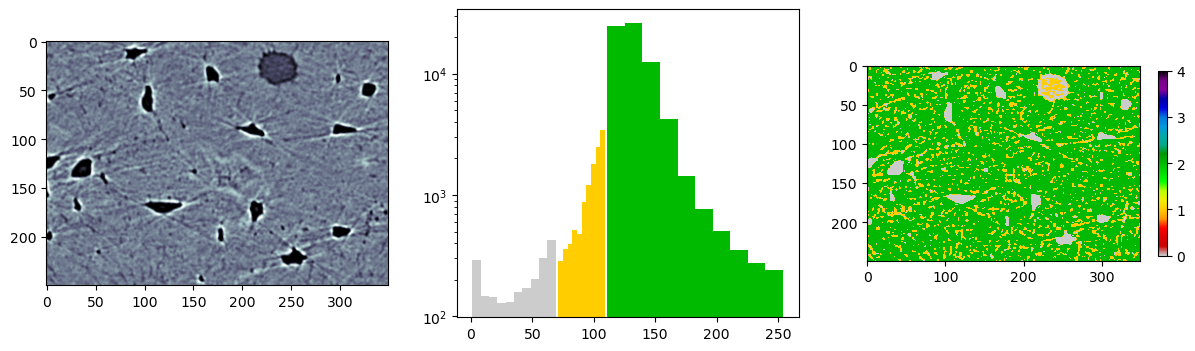

In [6]:
bone_img = imread("figures/bonegfiltslice.png")
np.random.seed(2018)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, 
                                    figsize = (15, 4))
cmap = plt.cm.nipy_spectral_r
ax1.imshow(bone_img, cmap = 'bone')
thresh_vals = [0, 70, 110, 255]
out_img = np.zeros_like(bone_img)
for i, (t_start, t_end) in enumerate(zip(thresh_vals, thresh_vals[1:])):
    thresh_reg = (bone_img>t_start) & (bone_img<t_end)
    ax2.hist(bone_img.ravel()[thresh_reg.ravel()], color = cmap(i/(len(thresh_vals))))
    out_img[thresh_reg] = i
ax2.set_yscale("log", nonpositive='clip')
th_ax = ax3.imshow(out_img, cmap = cmap, vmin = 0, vmax = len(thresh_vals),interpolation='none')
plt.colorbar(th_ax,shrink=0.6);

## Goldilocks Situation
Here we end up with a goldilocks situation 
- Mama bear and Papa Bear
- one is too low and the other is too high

[The Goldilocks principle](https://en.wikipedia.org/wiki/Goldilocks_principle)

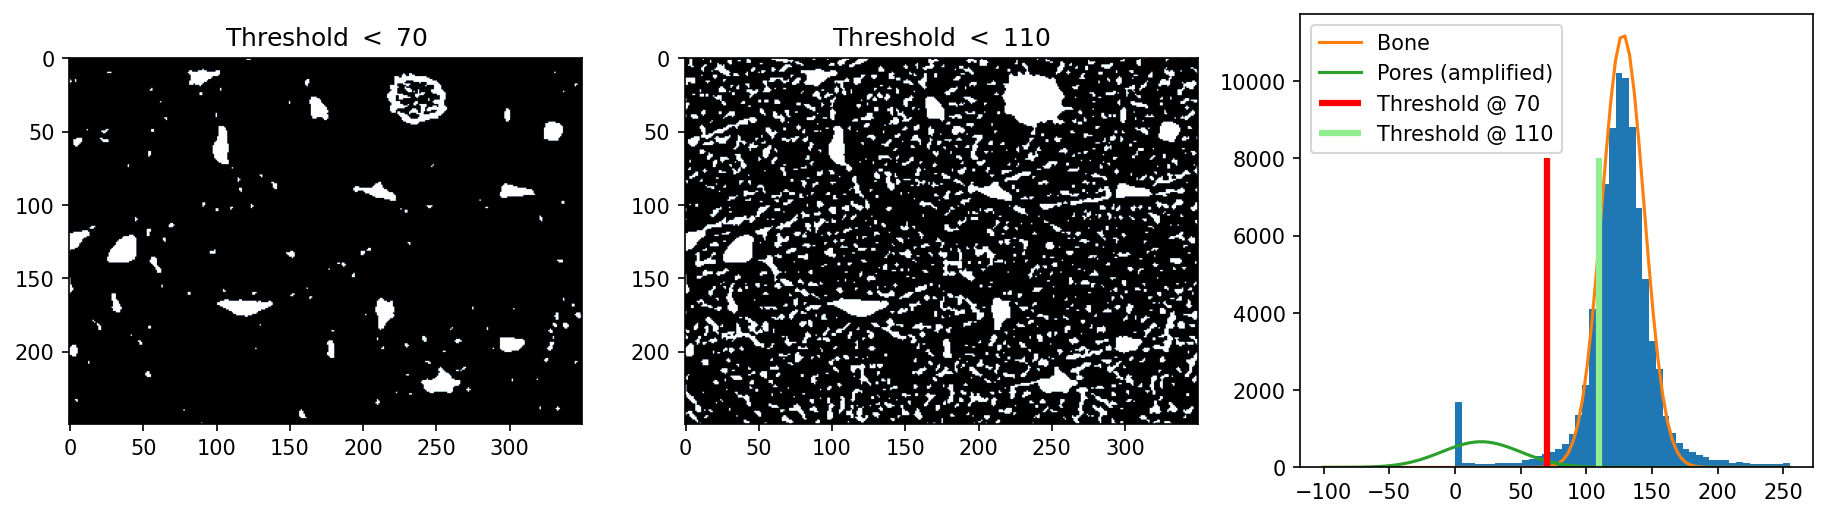

In [29]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize = (15, 4), dpi=150)
ax1.imshow(bone_img<thresh_vals[1], cmap = 'bone')
ax1.set_title('Threshold $<$ %d' % (thresh_vals[1]))
ax2.imshow(bone_img<thresh_vals[2], cmap = 'bone')
ax2.set_title('Threshold $<$ %d' % (thresh_vals[2]));
import scipy.stats as stats
ax3.hist(bone_img.ravel(),bins=50);
x=np.linspace(-100,255,100)
ax3.plot(x,4.5e5*stats.norm.pdf(x,128,16),label="Bone")
ax3.plot(x,5e4*stats.norm.pdf(x,20,30),label="Pores (amplified)")
ax3.vlines([70],ymin=0,ymax=8000,color='r', label="Threshold @ 70",lw=3)
ax3.vlines([110],ymin=0,ymax=8000,color='lightgreen',label="Threshold @ 110",lw=3)
ax3.legend();

### Baby Bear
We can thus follow a process for ending up with a happy medium of the two  

#### Hysteresis Thresholding: Reducing Pixels

Now we apply the following steps. 

1. Take the first threshold image with the highest (more strict) threshold
1. Remove the objects which are not cells (too small) using an opening operation.
1. Take a second threshold image with the higher value
1. Combine both threshold images
1. Keep the _between_ pixels which are connected (by looking again at a neighborhood $\mathcal{N}$) to the _air_ voxels and ignore the other ones. This goes back to our original supposition that the smaller structures are connected to the larger structures


In [15]:
%matplotlib inline
from skimage.morphology import dilation, opening, disk
from collections import OrderedDict

### Thresholding with hysteresis
__Step 1__ Apply several thresholds to the image

In [16]:
thresh_vals = [0, 70, 110, 255] 
step_list = OrderedDict()
step_list['Strict Threshold']     = bone_img<thresh_vals[1]
step_list['Remove Small Objects'] = opening(step_list['Strict Threshold'], disk(1))
step_list['Looser Threshold']     = bone_img<thresh_vals[2]
step_list['Both Thresholds']      = 1.0*step_list['Looser Threshold'] + 1.0*step_list['Remove Small Objects']

__Step 2__ Combine the different images
$$I_{ConnectedThresholds}=\delta{}(I_{NoSmallObjects})\cap{}I_{LooseThresh}$$

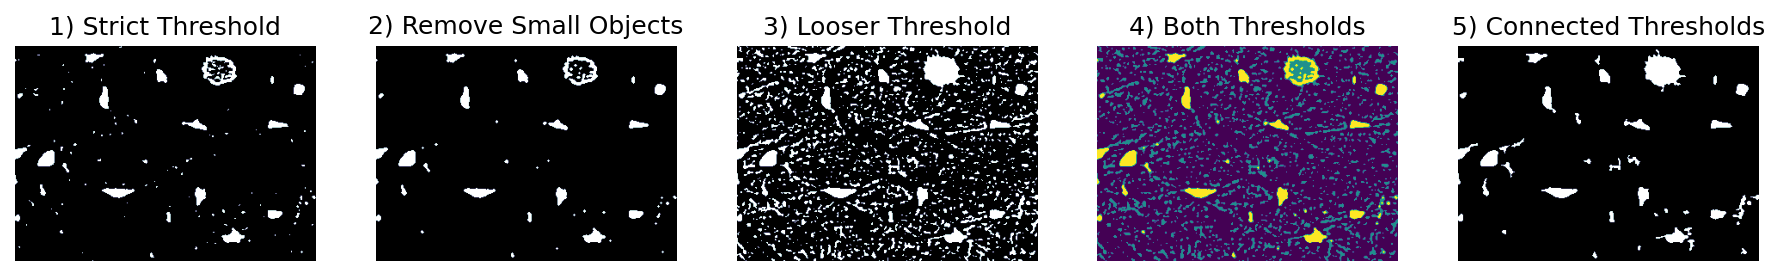

In [17]:
# the tricky part keeping the between images
step_list['Connected Thresholds'] = step_list['Remove Small Objects']

for i in range(10):
    step_list['Connected Thresholds'] = dilation(step_list['Connected Thresholds'] , 
                                                 disk(1.8)) & step_list['Looser Threshold']

fig, ax_steps = plt.subplots(1, len(step_list), figsize = (15, 5), dpi = 150)

for i, (c_ax, (c_title, c_img)) in enumerate(zip(ax_steps.flatten(), step_list.items()),1):
    c_ax.imshow(c_img, cmap = 'bone' if c_img.max()<=1 else 'viridis')
    c_ax.set_title('%d) %s' % (i, c_title)); c_ax.axis('off');

## Multiple thresholds
It is not uncommon to have multiple classes in an image

Setting thresholds at 0.6 and 2.2 makes sense...
<img src="figures/multithreshold.svg"/>

We see some misclassification that resembles a skin on the object!

### Investigation the virtual skin effect
Let's look at three different edge profiles in the image
<img src="figures/MultiClassProfiles.svg"/>

The virtual skin appears because the great transition from class 1 to 3 passes over several pixels and some of these pixels have values in the interval of class 2. These will be misclassified as class 2 and appear as the virtual skin in the segmented image.

### How to avoid segmentation problems at the edges

Often the edge segmentation only invloves a few pixels that can be handled in different ways.
E.g. 
- Hysteresis
- Guarded edges and region growing

<img src="figures/guardededge_demo.svg" />

The guarded edge method uses an edge enhancing filter like a Laplacian filter to create an edge image. It is not nescessary to handle all edge but only those with high amplitudes in the Laplacian image. These pixels will be excluded from the thresholding inititally. Once the obvious pixels have been assigned we can handle the edge using region growing to fill up the missing edge information. we could also use a Laplacian of Gaussian filter to increase the robustness for low SNR.

# More Complicated Images

As we briefly covered last time, many measurement techniques produce quite rich data. 
- Digital cameras produce 3 channels of color for each pixel (rather than just one intensity)
- MRI produces dozens of pieces of information for every voxel which are used when examining different _contrasts_ in the system.
- Raman-shift imaging produces an entire spectrum for each pixel
- Coherent diffraction techniques produce 2- (sometimes 3) diffraction patterns for each point.
$$ I(x,y) = \hat{f}(x,y) $$

## Feature Vectors

__A pairing between spatial information (position) and some other kind of information (value).__
$$ \vec{x} \rightarrow \vec{f} $$

We are used to seeing images in a grid format where the position indicates the row and column in the grid and the intensity (absorption, reflection, tip deflection, etc) is shown as a different color. We take an example here of text on a page. 

In [10]:
from skimage.data import page
import skimage.morphology as morph

page_image = page()
background = 255*gaussian(page_image, 20.0)
#background = morph.closing(page_image,morph.disk(51))
just_text = median(page_image, morph.disk(1))-background

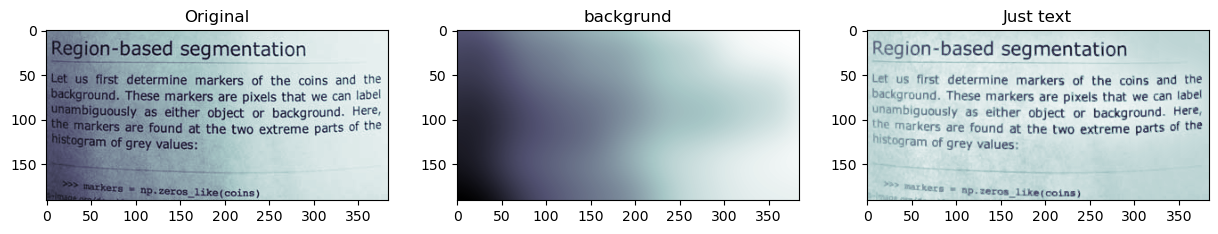

In [11]:
fig,ax = plt.subplots(1,3,figsize=[15,5])
ax[0].imshow(page_image, cmap = 'bone'); ax[0].set_title('Original');
ax[1].imshow(background, cmap = 'bone'); ax[1].set_title('backgrund');
ax[2].imshow(just_text,  cmap = 'bone'); ax[2].set_title('Just text');

The gradient in the original is removed using a combination of filters to reconstruct the illumination

$$\mathrm{JustText}=\underbrace{median_{disk}(img)}_{Noise}-\underbrace{G_{\sigma=20}*img}_{Illumination}$$

## Let's create a feature table

In [14]:
xx, yy = np.meshgrid(np.arange(page_image.shape[1]),
           np.arange(page_image.shape[0]))
page_table = pd.DataFrame(dict(x = xx.ravel(), 
                               y = yy.ravel(), 
                               intensity = page_image.ravel(),
                              is_text = just_text.ravel()>0))
page_table.sample(10)

x    y  intensity  is_text
47260   28  123         85    False
12549  261   32        227     True
15058   82   39        162     True
44250   90  115        141     True
30262  310   78         73    False
48116  116  125        124    False
43427   35  113        106     True
39079  295  101        215     True
35491  163   92        203    False
71447   23  186         45    False

## Inspect the features - Intensity vs. IsText

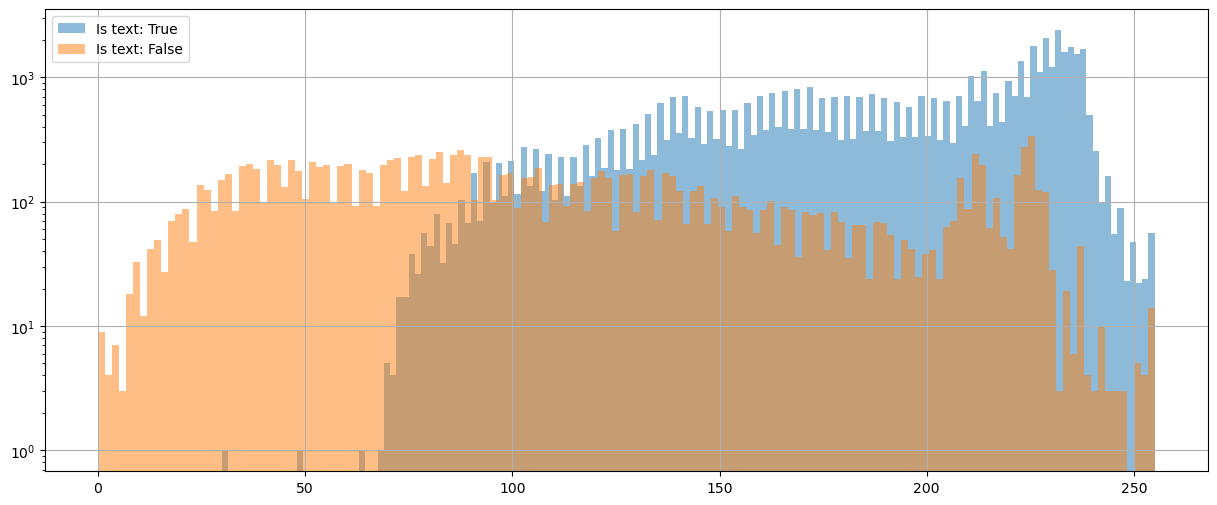

In [19]:
fig, ax1 = plt.subplots(1,1,figsize=(15,6))
for c_cat in [True,False] :
    page_table[page_table['is_text']==c_cat]['intensity'].hist(ax=ax1,
                                                          bins=150,
                                                          alpha=0.5,
                                                          label='Is text: {0}'.format(c_cat))
ax1.set_yscale("log", nonpositive='clip')
ax1.legend();

## What does the ROC curve look like?

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve    (page_table['is_text'], page_table['intensity'])
roc_auc     = roc_auc_score(page_table['is_text'], page_table['intensity'])

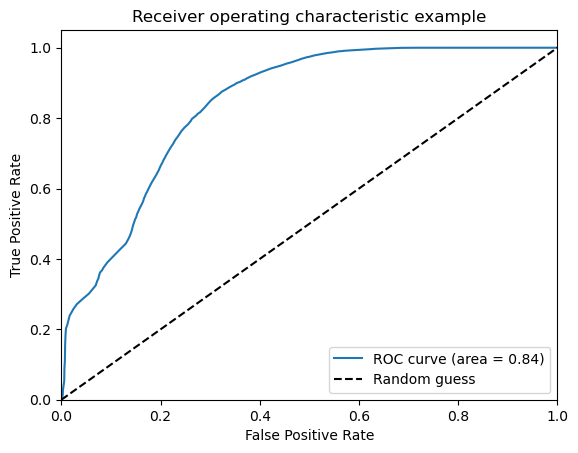

In [21]:
fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='ROC curve (area = {0:0.2})'.format(roc_auc))
ax.plot([0, 1], [0, 1], 'k--',label='Random guess')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate'); 
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example'); 
ax.legend(loc="lower right");

# Adding Information
Here we can improve the results by adding information.

As we discussed in the third lecture (enhancement), edge-enhancing filters can be very useful for classifying images.

How about:

$$f_{DoG}= G_{\sigma_1}*f - G_{\sigma_2}*f=(G_{\sigma_1} - G_{\sigma_2})*f,\quad \sigma_1<\sigma_2$$

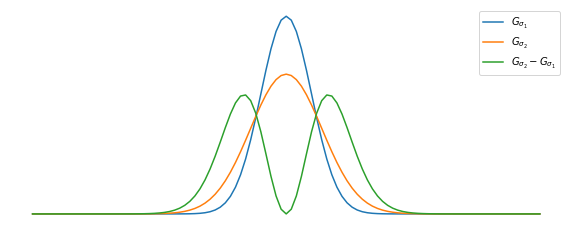

In [25]:
fig,ax=plt.subplots(1,figsize=(10,4))
x=np.linspace(-10,10,101)
g1=np.exp(-x**2/2)
g2=np.exp(-x**2/4)

ax.plot(x,g1/g1.sum(), label="$G_{\sigma_1}$")
ax.plot(x,g2/g2.sum(), label="$G_{\sigma_2}$")
ax.plot(x,(g2-g1)/(g2.sum()-g1.sum()),label="$G_{\sigma_2}-G_{\sigma_1}$")
ax.legend()
ax.axis("off");

### Testing with enhanced edges

In [26]:
def dog_filter(in_img, sig_1, sig_2):
    return gaussian(in_img, sig_1) - gaussian(in_img, sig_2)

page_edges = dog_filter(page_image, 0.5, 10)
page_table['edges'] = page_edges.ravel()

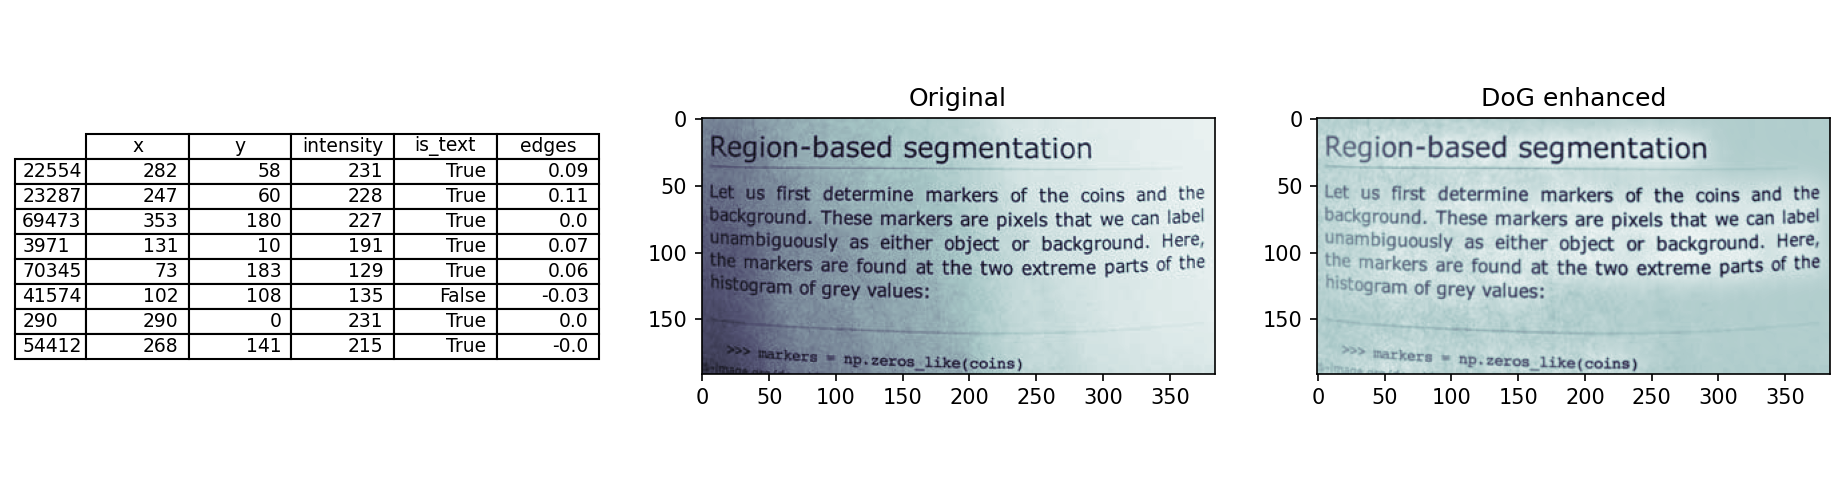

In [27]:
fig, ax = plt.subplots(1,3, figsize = (15, 4),dpi=150)
ax[1].imshow(page_image, cmap = 'bone'), ax[1].set_title('Original')
ax[2].imshow(page_edges, cmap = 'bone'), ax[2].set_title('DoG enhanced')

pd.plotting.table(data=page_table.sample(8).round(decimals=2), ax=ax[0], loc='center')
ax[0].axis('off');

## Histogram of enhanced image

Let's look at the gray level distribution after applying the enhancement filter.

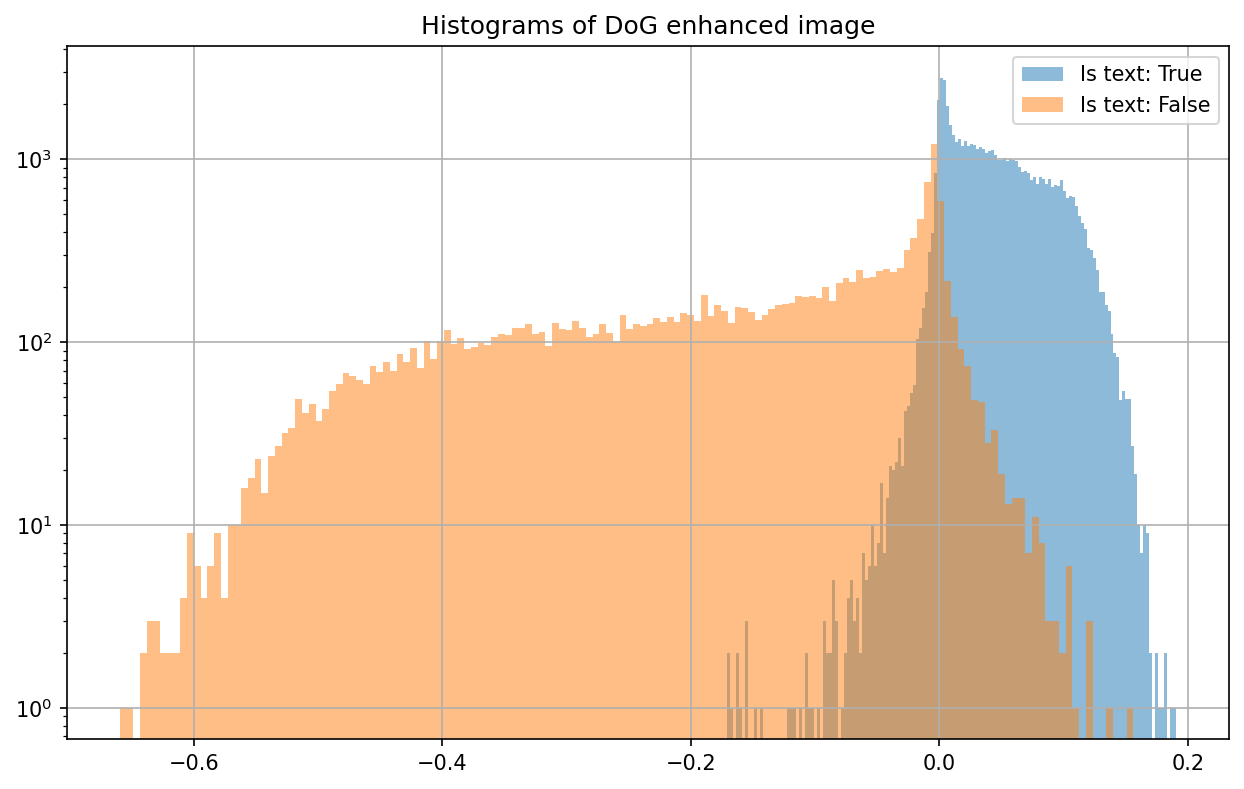

In [29]:
fig, ax = plt.subplots(1, figsize=(10,6),dpi=150)

for c_cat in [True,False] :
    page_table[page_table['is_text']==c_cat]['edges'].hist(ax=ax,
                                                          bins=150,
                                                          alpha=0.5,
                                                          label='Is text: {0}'.format(c_cat))
ax.set_yscale("log", nonpositive='clip')
ax.legend();
ax.set_title('Histograms of DoG enhanced image'); ax.set_yscale("log", nonpositive='clip'); ax.legend();

We see here that the text pixels have been compressed into a narrow interval with some tail toward the lower intensities.

## Checking the ROC performance

Now, we can compute the ROC curve to see if the enhanced image performs better than the original.

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score 
fpr2, tpr2, _ = roc_curve(page_table['is_text'], 
                          page_table['intensity']/1000.0+page_table['edges'])
roc_auc2      = roc_auc_score(page_table['is_text'], 
                         page_table['intensity']/1000.0+page_table['edges'])

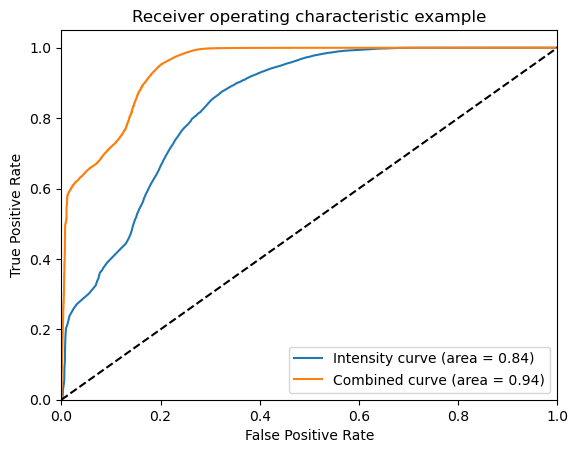

In [31]:
# Visualization
fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='Intensity curve (area = %0.2f)' % roc_auc)
ax.plot(fpr2, tpr2, label='Combined curve (area = %0.2f)' % roc_auc2)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])    
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right");

We can see that it is doing better already bey looking at the curves. Also the AUC confirms this which is great. We have made and improvement thanks to the preprocessing of the data.

## Why does the second filter perform better?

We can see the reason for the performance improvement when we compare the histograms. 

Text(0.5, 1.0, 'Edges')

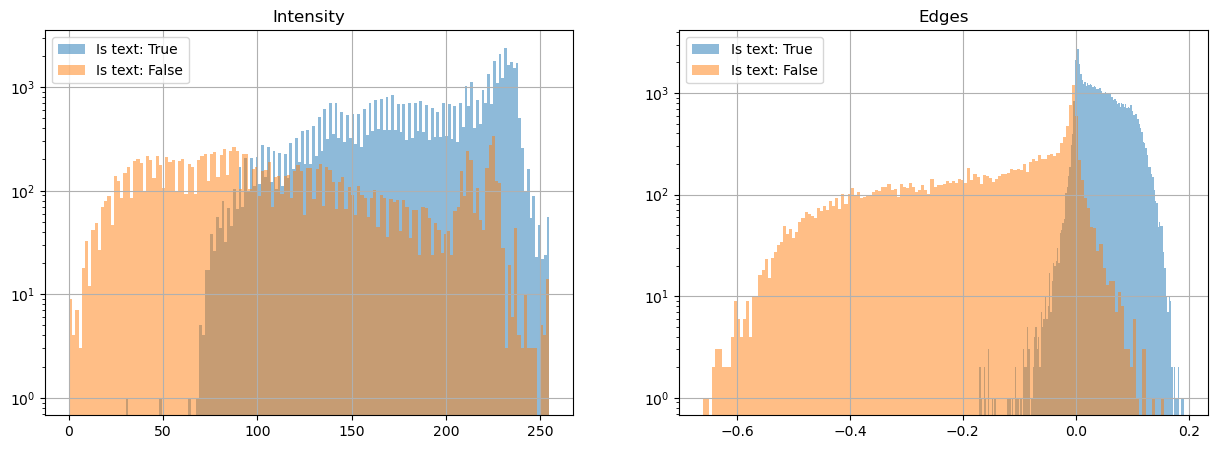

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 5))

for c_cat in [True,False] :
    page_table[page_table['is_text']==c_cat]['intensity'].hist(ax=ax1,
                                                          bins=150,
                                                          alpha=0.5,
                                                          label='Is text: {0}'.format(c_cat))
ax1.set_yscale("log", nonpositive='clip')
ax1.legend();
ax1.set_title('Intensity')

for c_cat in [True,False] :
    page_table[page_table['is_text']==c_cat]['edges'].hist(ax=ax2,
                                                          bins=150,
                                                          alpha=0.5,
                                                          label='Is text: {0}'.format(c_cat))
ax2.set_yscale("log", nonpositive='clip')
ax2.legend();
ax2.set_title('Edges');


The two classes are more or less overlapping each other in the original image. After filtering the gray levels are more compact for each class with some slight overlap in the tail distributions.

# Clustering / Classification (Unsupervised)

Unsupervised segmentation method tries to make sense of the that without any prior knowledge. They may need an initialization parameter telling how many classes are expected in the data, but beyond that you don't have to provide much more information. 

- Automatic clustering of multidimensional data into groups based on a distance metric
- Fast and scalable to petabytes of data (Google, Facebook, Twitter, etc. use it regularly to classify customers, advertisements, queries)
- __Input__ = feature vectors, distance metric, number of groups
- __Output__ = a classification for each feature vector to a group

## Example data

With clustering methods you aim to group data points together into a limited number of clusters. Here, we start to look at an example where each data point has two values. 

The test data is generated using the ```make_blobs``` function. 

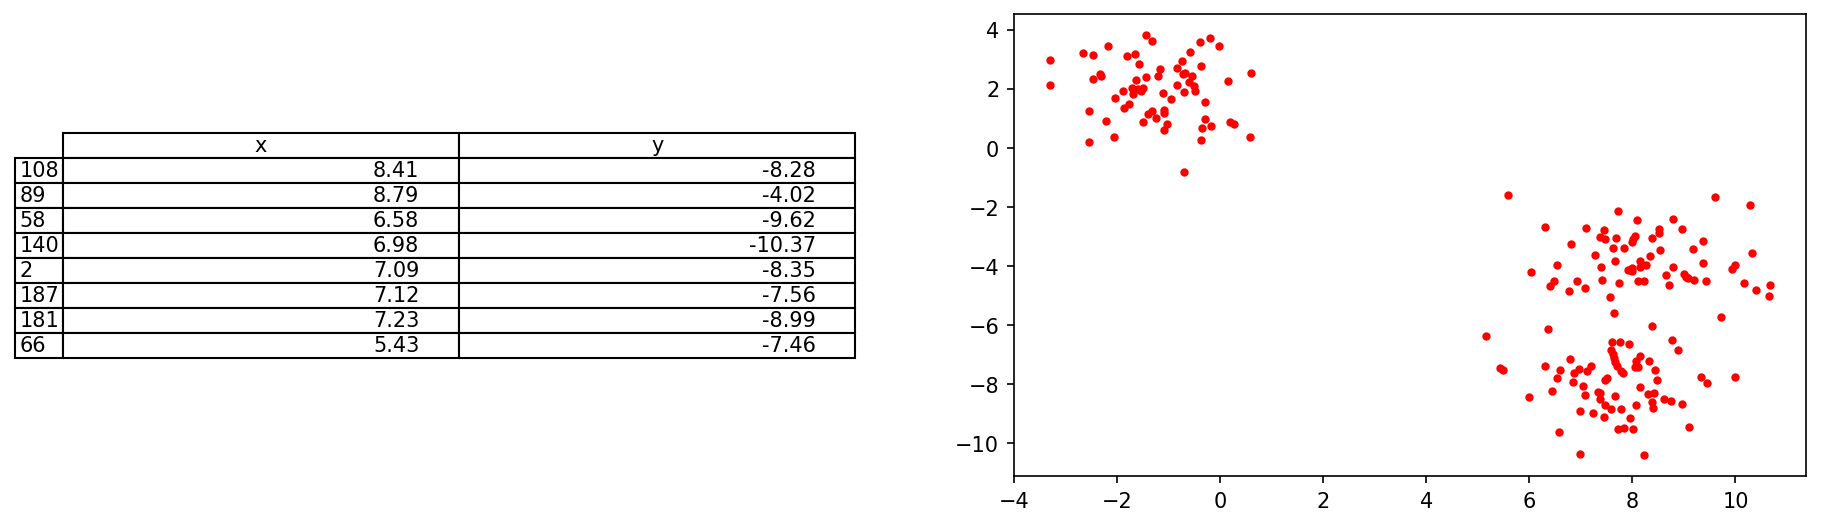

In [9]:
test_pts = pd.DataFrame(make_blobs(n_samples=200, random_state=2018)[
                        0], columns=['x', 'y'])

fig, ax = plt.subplots(1,2, figsize = (15, 4),dpi=150)

ax[1].plot(test_pts.x, test_pts.y, 'r.')
pd.plotting.table(data=test_pts.sample(8).round(decimals=2), ax=ax[0], loc='center')
ax[0].axis('off');

### First clustering attempt

The generated data set has two obvoius clusters, but if look closer it is even possible to identify three clusters. We will now use this data to try the k-means algorithm.

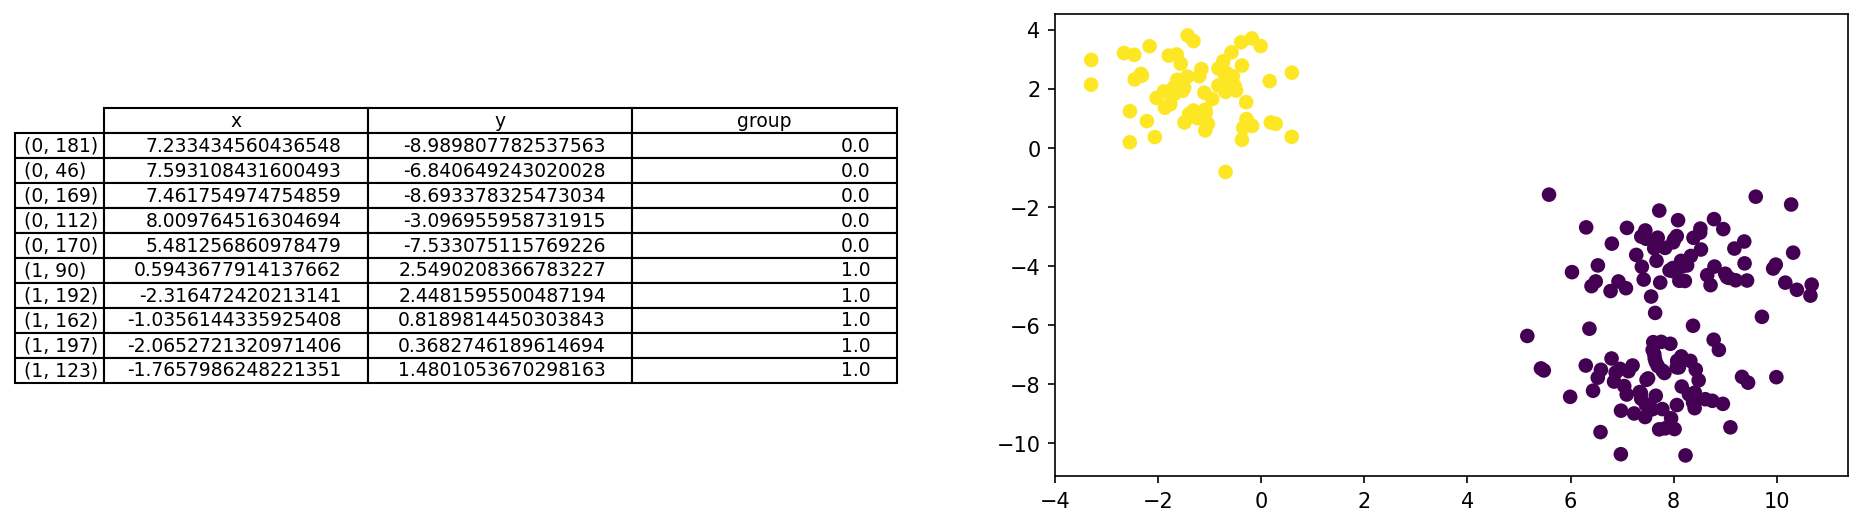

In [10]:
km = KMeans(n_clusters=2, random_state=2018,n_init='auto')
n_grp = km.fit_predict(test_pts)
grp_pts = test_pts.copy()
grp_pts['group'] = n_grp
grp_pts.groupby(['group']).apply(lambda x: x.sample(5))

# Plotting
fig, ax = plt.subplots(1,2, figsize = (15, 4),dpi=150)
ax[1].scatter(test_pts.x, test_pts.y, c=n_grp)
pd.plotting.table(data=grp_pts.groupby(['group']).apply(lambda x: x.sample(5)), ax=ax[0], loc='center')
ax[0].axis('off');

## K-Means Algorithm

We give as an initial parameter 
- the number of groups we want to find 
- and possibly a criteria for removing groups that are too similar

<figure><img src="figures/FuzzyCMeans.svg" style="height:500px"/></figure>

It is an iterative method that starts with a label image where each pixel has a random label assignment. Each iteration involves the following steps:
1. Compute current centroids based on the o current labels
2. Compute the value distance for each pixel to the each centroid. Select the class which is closest. 
3. Reassign the class value in the label image.
4. Repeat until no pixels are updated.

The distance from pixel _i_ to centroid _j_ is usually computed as $||p_i - c_j||_2$.

```{figure} figures/FuzzyCMeans.pdf
---
scale: 100%
---
Flow chart for the k-means clustering iterations. 
```

### Increasing the number of clusters

In this example we will use the blob data we previously generated and to see how k-means behave when we select different numbers of clusters.

Let's try k-means with N=2,3,4 clusters:

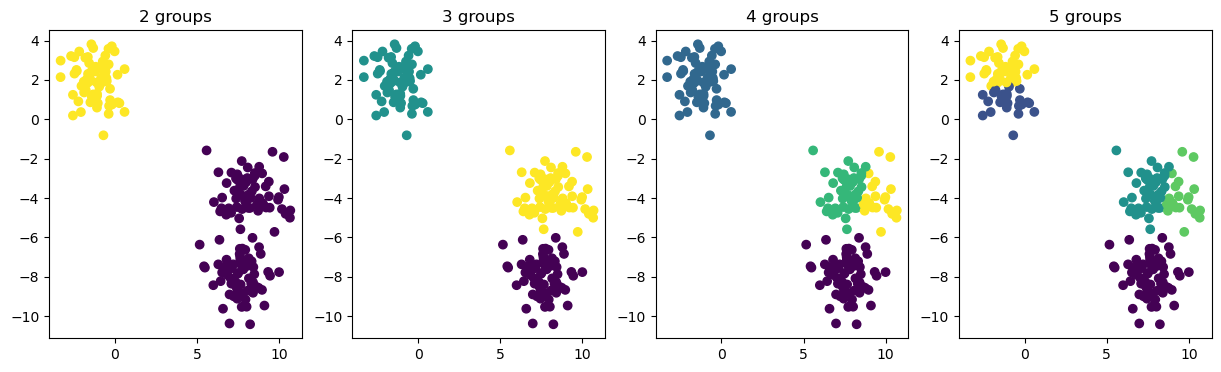

In [11]:
clusters=[2,3,4,5]
fig, axes = plt.subplots(1,len(clusters),figsize=(15,4))

for ax,N in zip(axes,clusters) :
    km    = KMeans(n_clusters=N, random_state=2018,n_init='auto'); 
    n_grp = km.fit_predict(test_pts)
    
    ax.scatter(test_pts.x, test_pts.y, c=n_grp)
    ax.set_title('{0} groups'.format(N))

__Note:__  If you look for N groups you will always find N groups with K-Means, whether or not they make any sense

When we select two clusters there is a natural separation between the two clusters we easily spotted by just looking at the data. When the number of clusters is increased to three, we again see a cluster separation that makes sense. Now, when the number of clusters is increased yet another time we see that one of the clusters is split once more. This time it is how ever questionable if the number of clusters makes sense. From this example, we see that it is important to be aware of problems related to over segmentation.

## What vector space do we have?
- Sometimes represent physical locations (classify swiss people into cities)
- Can include intensity or color (K-means can be used as a thresholding technique when you give it image intensity as the vector and tell it to find two or more groups)
- Can also include orientation, shape, or in extreme cases full spectra (chemically sensitive imaging)

## Add spatial information to k-means

It is important to note that k-means by definition is not position sensitive. Clustering is by definition not position sensitive, mainly measures distances between values and distributions. The position can however be included as additional components in the data vectors. You can also add neighborhood information using filtered images as additionals components of the feature vectors.

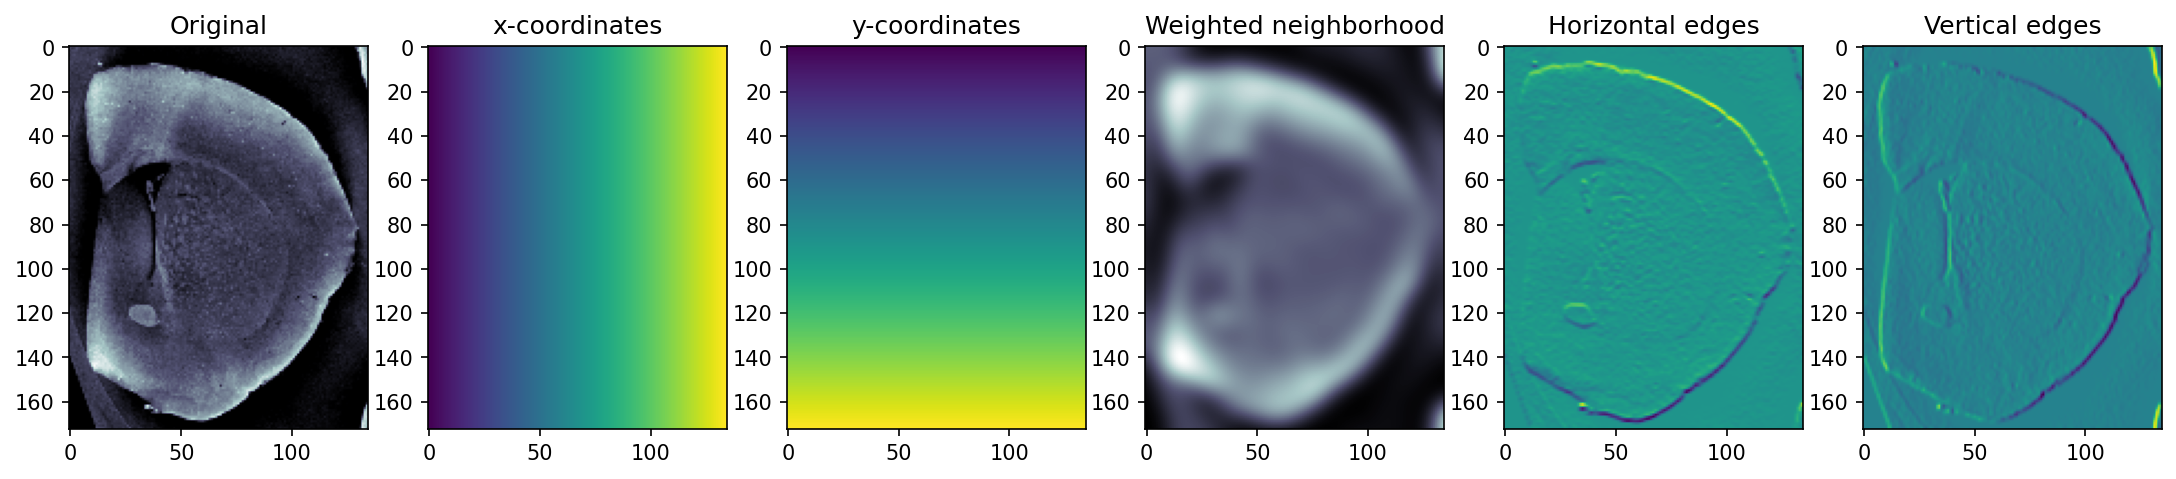

In [4]:
cortex_img = imread("figures/cortex.png")[::3, ::3]/1000.0
fig,ax = plt.subplots(1,6,figsize=(18,5),dpi=150); 
xx, yy = np.meshgrid(np.arange(cortex_img.shape[1]),
                     np.arange(cortex_img.shape[0]))
ax[0].imshow(cortex_img,cmap='bone'), ax[0].set_title('Original')
ax[1].imshow(xx), ax[1].set_title('x-coordinates')
ax[2].imshow(yy), ax[2].set_title('y-coordinates')
ax[3].imshow(flt.gaussian(cortex_img, sigma=5),cmap='bone'), ax[3].set_title('Weighted neighborhood')
ax[4].imshow(flt.sobel_h(cortex_img)),ax[4].set_title('Horizontal edges')
ax[5].imshow(flt.sobel_v(cortex_img)),ax[5].set_title('Vertical edges');

### K-Means Applied to Cortex Image

In this example we use position and intensity as feature vectors.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
%matplotlib inline

In [6]:
cortex_img = imread("figures/cortex.png")[::3, ::3]/1000.0
np.random.seed(2018)
xx, yy = np.meshgrid(np.arange(cortex_img.shape[1]),np.arange(cortex_img.shape[0]))

cortex_df = pd.DataFrame(dict(x=xx.ravel(),
                              y=yy.ravel(),
                              intensity=cortex_img.ravel()))

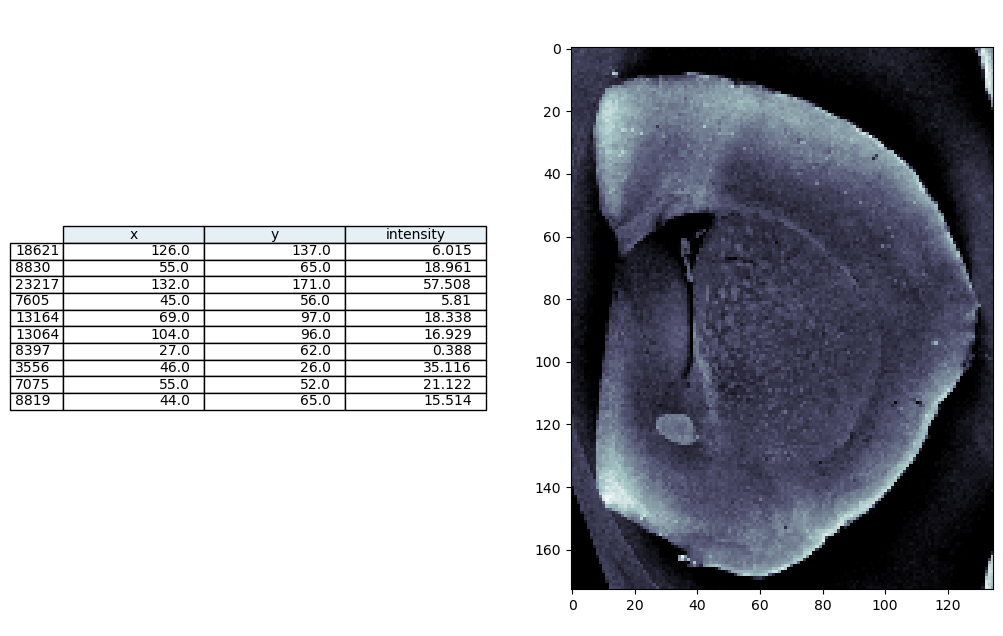

In [5]:
fig, (ax0,ax1) = plt.subplots(1, 2,figsize=(12, 8))
ax1.imshow(cortex_img, cmap='bone')

ccolors = plt.cm.BuPu(np.full(3, 0.1))

pd.plotting.table(data=cortex_df.sample(10), ax=ax0, loc='center',colColours=ccolors,fontsize=20)
ax0.axis('off');

### First segmentation attempt with k-means on brain image
We use $N_{clusters}=4$

In [30]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4, random_state=2018,n_init='auto')
cortex_df['group'] = km.fit_predict(cortex_df[['x', 'y', 'intensity']].values)
cortex_seg         = cortex_df['group'].values.reshape(cortex_img.shape)

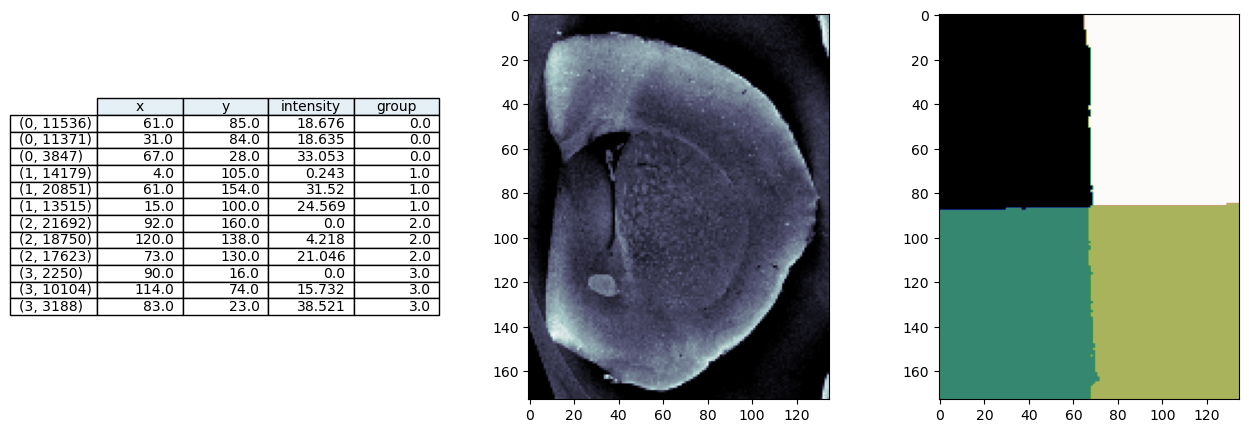

In [34]:
fig, (ax0,ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(cortex_img, cmap='bone')
ax2.imshow(cortex_seg, cmap='gist_earth')

ccolors = plt.cm.BuPu(np.full(4, 0.1))

pd.plotting.table(data=cortex_df.groupby(['group']).apply(lambda x: x.sample(3)), ax=ax0, loc='center',colColours=ccolors,fontsize=20)
ax0.axis('off');

### Why is the image segmented like this?

### Rescaling components 

Since the distance is currently calculated by $||\vec{v}_i-\vec{v}_j||$ and the values for the position is much larger than the values for the _Intensity_ , _Sobel_ or _Gaussian_ they need to be rescaled so they all fit on the same axis 
$$\vec{v} = \left\{\frac{x}{10}, \frac{y}{10}, \textrm{Intensity}\right\}$$

$N_{clusters}$=4

In [ ]:
km = KMeans(n_clusters=4, random_state=2018,n_init='auto')
scale_cortex_df   = cortex_df.copy()
scale_cortex_df.x = scale_cortex_df.x/10
scale_cortex_df.y = scale_cortex_df.y/10
scale_cortex_df['group'] = km.fit_predict(scale_cortex_df[['x', 'y', 'intensity']].values)
cortex_seg=scale_cortex_df['group'].values.reshape(cortex_img.shape)

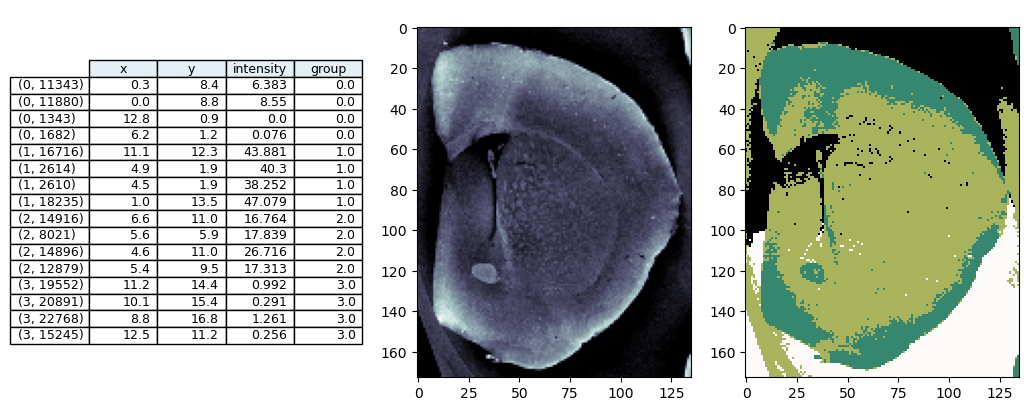

In [13]:
fig, (ax0,ax1, ax2) = plt.subplots(1, 3,
                               figsize=(12, 5))
ax1.imshow(cortex_img, cmap='bone')
ax2.imshow(cortex_seg,
           cmap='gist_earth',interpolation='none')

ccolors = plt.cm.BuPu(np.full(4, 0.1))
pd.plotting.table(data=scale_cortex_df.groupby(['group']).apply(lambda x: x.sample(4)), ax=ax0, loc='center',colColours=ccolors,fontsize=20)
ax0.axis('off');

#### Let's try a different position scaling

$$\vec{v} = \left\{\frac{x}{5}, \frac{y}{5}, \textrm{Intensity}\right\}$$
$N_{clusters}$=5

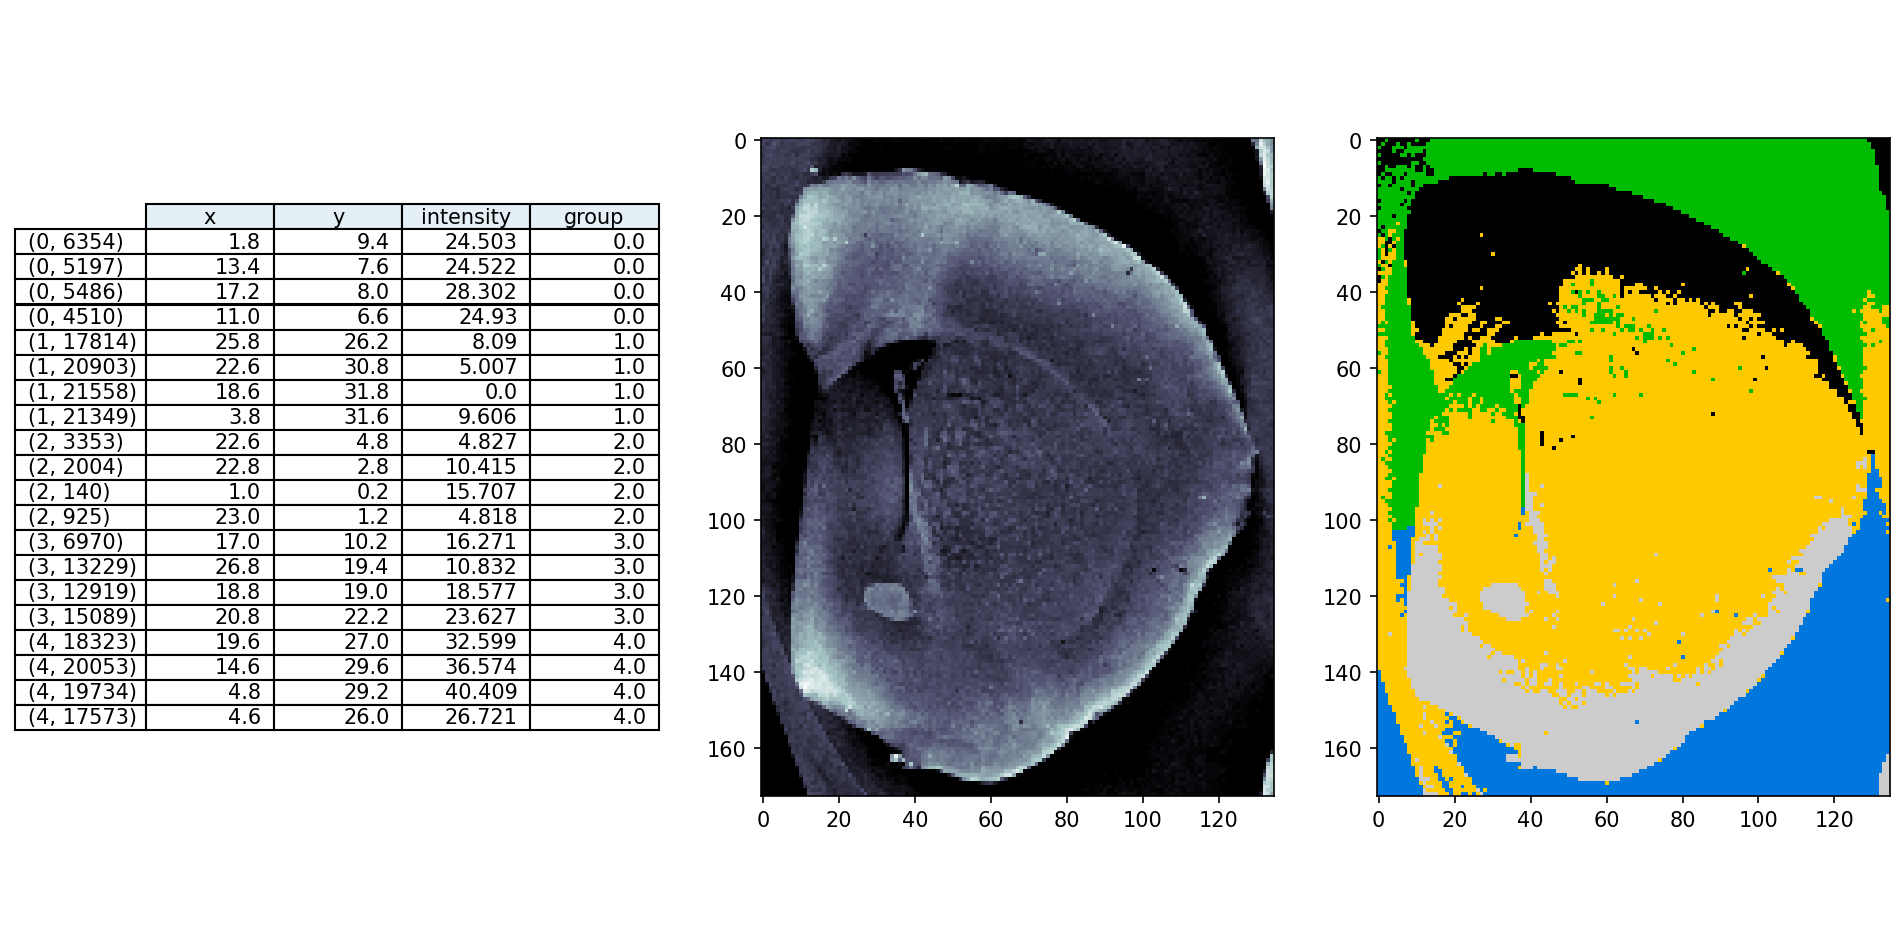

In [36]:
km = KMeans(n_clusters=5, random_state=2019)
scale_cortex_df = cortex_df.copy()
scale_cortex_df.x = scale_cortex_df.x/5
scale_cortex_df.y = scale_cortex_df.y/5
scale_cortex_df['group'] = km.fit_predict(
    scale_cortex_df[['x', 'y', 'intensity']].values)

fig, (ax0,ax1, ax2) = plt.subplots(1, 3,
                               figsize=(15, 8), dpi=150)
ax1.imshow(cortex_img, cmap='bone')
ax2.imshow(scale_cortex_df['group'].values.reshape(cortex_img.shape),
           cmap='nipy_spectral')
scale_cortex_df.groupby(['group']).apply(lambda x: x.sample(3))

ccolors = plt.cm.BuPu(np.full(4, 0.1))
pd.plotting.table(data=scale_cortex_df.groupby(['group']).apply(lambda x: x.sample(4)), ax=ax0, loc='center',colColours=ccolors,fontsize=20)
ax0.axis('off');

## When can clustering be used on images?

Clustering and in particular k-means are often used for imaging applications. 

- Single images (Cortex example)

It does not make much sense to segment using only the image intensity with k-means. This would result in thresholding similar to the one provided by Otsu's method. If you, however, add spatial information like edges and positions it starts be interesting to use k-means for a single image.

- Bimodal data

In recent years, several neutron imaging instruments have have installed an X-ray source to provide complementary information to the neutron images. This is a great mix of information for k-means based segmenation. Another type of bimodal data is when a grating interferometry setup is used. This setup provides three images revealing different aspects of the samples. Again, here it a great combination as these data are 

- Hyper-spectral data ([materials science example](https://imaginglectures.github.io/MLSegmentation4NI/))

Many materials have a characteristic response the neutron wavelength. This is used in many materials science experiments, in particular experiments performed at pulsed neutron sources. The data from such experiments result in a spectrum response for each pixel. This means each pixel can be a vector of >1000 elements.

# Quad trees
Split the image in subregions until a criterion is fulfilled:

## Principle

A quad tree is created by dividing image into four sections. Next you iterate the following steps until no more splits are made:
1. Compute metric (e.g. max-min or standard deviation) for each new sub-region
2. If the metric is greater than a threshold slit the region into four new regions
3. Otherwise leave it as is, the region is "constant" according to the criterion.

The figure below illustrates how an image is decomposed into a quad tree. Here you can see that the regions near edges are much smaller than in constant valued regions.

```{figure} figures/quad_principle.png
---
scale: 50%
---
A quad tree decomposition.
```

<table>
    <tr><th>Original</th><th>Split 1</th><th>Split 2</th><th>Split 3</th><th>Split 4</th><th>Split 5</th></tr>
    <tr><td><img src="figures/quad_principle_256.png" /></td>
        <td><img src="figures/quad_principle_128.png" /></td>
        <td><img src="figures/quad_principle_64.png" /></td>
        <td><img src="figures/quad_principle_32.png" /></td>
        <td><img src="figures/quad_principle_16.png" /></td>
        <td><img src="figures/quad_principle_8.png" /></td>
</tr>
</table>

## Quad tree example

Next we try to decompose an natural image as a quad tree.
```{figure} figures/qt_demo.pdf
---
scale: 100%
---
A neutron radiograph of a grasshopper decomposed using a quad tree.
```    

<td><img src="figures/qt_demo.svg" style="height:600px"/></td>

# Superpixels

An approach for simplifying images by performing a clustering and forming super-pixels from groups of similar pixels. 
https://ivrl.epfl.ch/research/superpixels

<table>
    <tr>
<td><img src="https://www.epfl.ch/labs/ivrl/wp-content/uploads/2018/08/54082_combo.jpg"/></td>
<td><img src="https://www.epfl.ch/labs/ivrl/wp-content/uploads/2018/08/210088_combo.jpg"/></td>
<td><img src="https://www.epfl.ch/labs/ivrl/wp-content/uploads/2018/08/302003_combo.jpg"/></td>
        <tr>
</table>

[DOI](https://doi.org/10.1109/TPAMI.2012.120)

## Why use superpixels

Super pixels
- Drastically reduced data size, 
- Serves as an initial segmentation showing spatially meaningful groups

---
### A super-pixel example
We start with an example of shale with multiple phases
- rock
- clay
- pore

### Basic thresholds

We start the analysis with using plain threshold based on the histogram. You can clearly see in the histogram that the chosen thresholds will produce many misclassified pixels. This approach will give a hint on the regions but is not very precise.

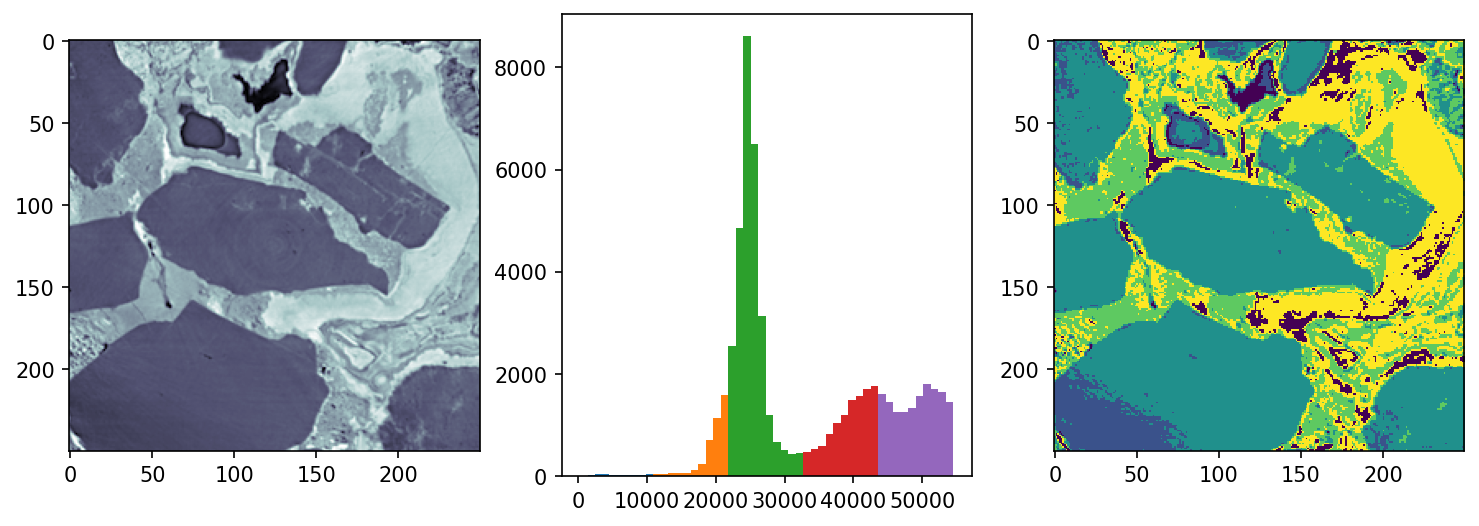

In [15]:
shale_img = imread("figures/shale-slice.tiff")
np.random.seed(2018)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,
                                    figsize=(12, 4), dpi=150)
ax1.imshow(shale_img, cmap='bone')
thresh_vals = np.linspace(shale_img.min(), shale_img.max(), 5+2)[:-1]
out_img = np.zeros_like(shale_img)
for i, (t_start, t_end) in enumerate(zip(thresh_vals, thresh_vals[1:])):
    thresh_reg = (shale_img > t_start) & (shale_img < t_end)
    ax2.hist(shale_img.ravel()[thresh_reg.ravel()])
    out_img[thresh_reg] = i
# ax3.imshow(out_img, cmap='gist_earth',interpolation='none');
ax3.imshow(out_img, cmap='viridis',interpolation='none');

## Super pixels

Super-pixels in as sense an evolution of the quad tree. They are not bound to the strict splitting scheme but can generate regions with limited variations of arbitrary shape.

Using the SLIC algorithm

In [41]:
from skimage.segmentation import slic, mark_boundaries

shale_segs = slic(shale_img,
                  n_segments=100,
                  compactness=5e-2,
                  sigma=3.0,
                  start_label=1)

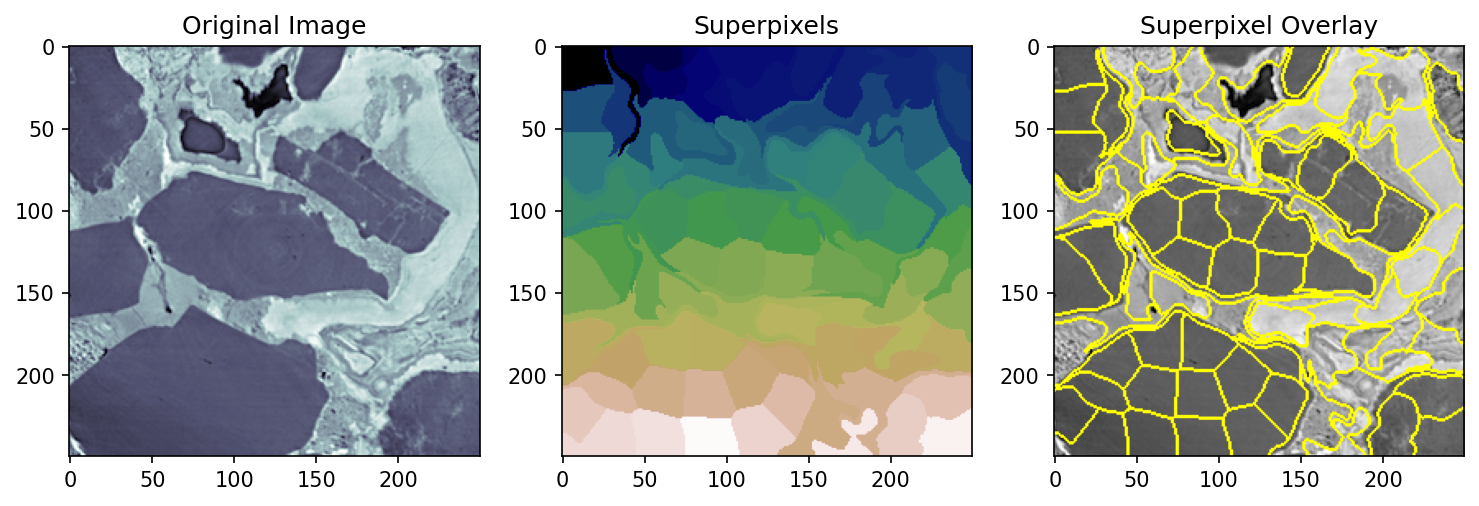

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150)
ax1.imshow(shale_img, cmap='bone')
ax1.set_title('Original Image')
ax2.imshow(shale_segs, cmap='gist_earth')
ax2.set_title('Superpixels')
ax3.imshow(mark_boundaries(shale_img, shale_segs))
ax3.set_title('Superpixel Overlay');

## Merging super pixels

Usually, to many super pixels are identified. They are also not really representing the feature shapes in the image. The super-pixels currently also only have pixel indexes as values. In the next step we assign the average values of each super-pixel. This produces a patchy image that ideally is easier to interpret.

In [ ]:
flat_shale_img = shale_img.copy()
for s_idx in np.unique(shale_segs.ravel()):
    flat_shale_img[shale_segs == s_idx] = np.mean(
        flat_shale_img[shale_segs == s_idx])
    

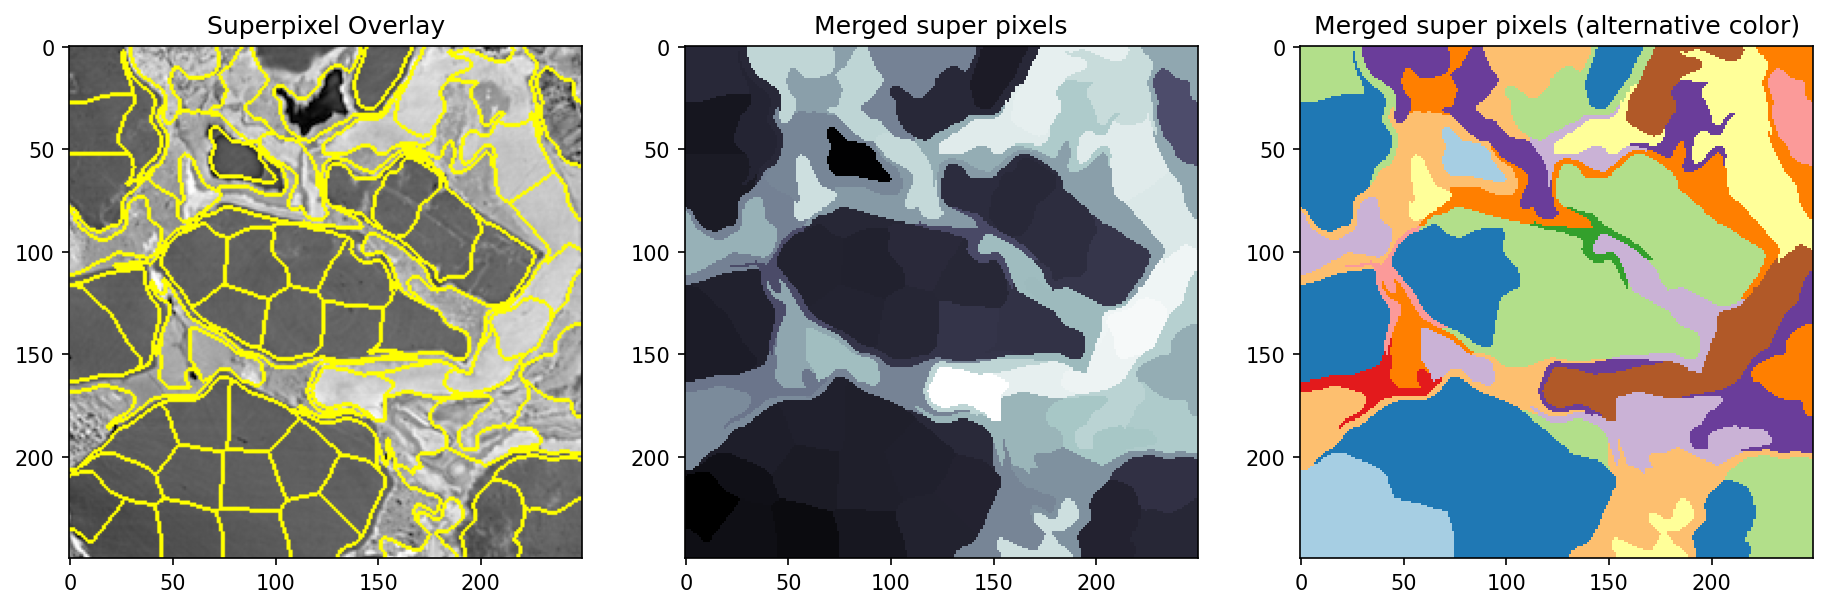

In [43]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(mark_boundaries(shale_img, shale_segs))
ax1.set_title('Superpixel Overlay')
ax2.imshow(flat_shale_img, cmap='bone',interpolation='none');   
ax2.set_title('Merged super pixels')
ax3.imshow(flat_shale_img, cmap='Paired',interpolation='none'); 
ax3.set_title('Merged super pixels (alternative color)');

## Segmentation using super pixels


In [ ]:
thresh_vals = np.linspace(flat_shale_img.min(), flat_shale_img.max(), 5+2)[:-1]
sp_out_img = np.zeros_like(flat_shale_img)
for i, (t_start, t_end) in enumerate(zip(thresh_vals, thresh_vals[1:])):
    thresh_reg = (flat_shale_img > t_start) & (flat_shale_img < t_end)
    sp_out_img[thresh_reg] = i

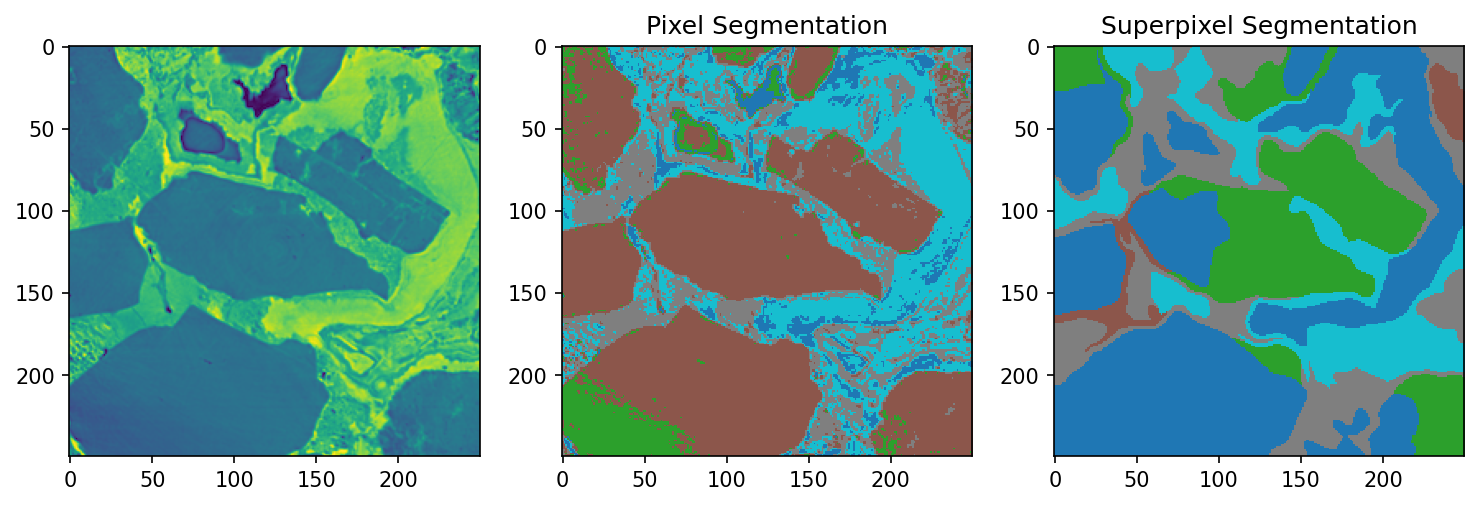

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(12, 4), dpi=150)
ax1.imshow(shale_img, cmap='viridis')    
ax2.imshow(out_img, cmap='tab10',interpolation='none')
ax2 .set_title('Pixel Segmentation')
ax3.imshow(sp_out_img, cmap='tab10',interpolation='none')
ax3.set_title('Superpixel Segmentation');

# Probabilistic Models of Segmentation

A more general approach is to use a probabilistic model to segmentation. We start with our image $I(\vec{x})$ $\forall \vec{x}\in \mathbb{R}^N$ and we classify it into two phases $\alpha$ and $\beta$

$$P(\{\vec{x} , I(\vec{x})\}  | \alpha) \propto P(\alpha) + P(I(\vec{x}) | \alpha)+  P\left(\sum_{x^{\prime} \in \mathcal{N}} I(\vec{x^{\prime}}) |  \alpha\right)$$
- $P(\{\vec{x} , f(\vec{x})\}  | \alpha)$ the probability a given pixel is in phase $\alpha$ given we know it's position and value (what we are trying to estimate)
- $P(\alpha)$ probability of any pixel in an image being part of the phase (expected volume fraction of that phase)
- $P(I(\vec{x}) | \alpha)$ probability adjustment based on knowing the value of $I$ at the given point (standard threshold)
- $P(f(\vec{x^{\prime}}) |  \alpha)$ are the collective probability adjustments based on knowing the value of a pixels neighbors (very simple version of [Markov Random Field](http://en.wikipedia.org/wiki/Markov_random_field) approaches)

# Summary

## Histogram based thresholding
- Otsu and others
- Hysteresis thresholding

## Clustering - K-means
- Add position information

## Similar region segmentations
- Quad trees
- Super pixels